<font color = 'yellow'>
<h2>Isi konten:</h2>

[Pendahuluan](#1)
1. [Persiapan Dataset dan Lingkungan Eksperimen](#2)
2. [Konfigurasi Parameter dan Pembagian Dataset](#3)
3. [Eksplorasi Awal Dataset (EDA)](#4)
4. [Visualisasi Contoh Data: Gambar Acak per Kelas](#5)     
5. [Augmentasi Data dan Visualisasinya](#6)
6. [Callback untuk Penghentian Otomatis dan Penyesuaian Learning Rate](#7)
7. [Arsitektur Model dan Proses Pelatihan](#8)
8. [Prediksi Cacat Menggunakan Model Xception](#9)
9. [Analisis dan klasifikasi cacat secara mendalam menggunakan XAI](#10)
10. [Laporan Hasil Deteksi dan Self Healing Insight](#11)

[Penutup](#12)

<a id = "1"></a><br>
## Pendahuluan

- Sistem ini merupakan solusi inovatif berbasis <b><i>Explainable AI</i></b> (XAI) untuk <b>deteksi</b> dan <b>klasifikasi cacat manufaktur</b> pada produk <i>casting</i> menggunakan citra visual. Sebagai catatan, pengembangan ini didasarkan pada pendekatan <i>open-source</i> dari salah satu <i>baseline model</i> yang disediakan dalam dataset <u>"Kaggle Real-Life Industrial Dataset of Casting Product"</u>. Penelitian ini menggunakan arsitektur pemodelan yang sama (<i>pretrained Xception</i>), namun secara signifikan dikembangkan ulang dari sisi visualisasi (Grad-CAM), <i>bounding box</i> segmentasi cacat, klasifikasi <i>multi-label</i> heuristik, hingga penambahan fitur <b>rekomendasi <i>self-healing</i></b> berbasis karakteristik cacat (<i>XAI-based repair insight</i>). Sistem tidak hanya memprediksi apakah sebuah produk cacat, tetapi juga <b>menjelaskan letak, jenis, dan karakteristik spasial dari cacat yang ditemukan</b> secara transparan dan dapat dipertanggungjawabkan.

- Keunggulan teknis sistem ini terletak pada <b>kemampuannya</b> dalam memberikan <b>deteksi <i>multi-label</i> cacat</b> secara visual dengan <i>heatmap overlay</i>, klasterisasi area bermasalah menggunakan pendekatan morfologi maupun DBSCAN, serta <b>pelaporan hasil</b> dalam bentuk JSON dan teks yang kaya informasi. Sistem ini menyajikan <i>output</i> yang tidak hanya <i><b>interpretable</i>, tetapi juga <i>actionable</b></i>, memungkinkan <i>engineer</i> untuk memahami penyebab cacat dan merespons secara tepat. Di sisi lain, dari perspektif bisnis, solusi ini membawa nilai tambah strategis dalam <i>quality control</i>: menurunkan rasio scrap, meminimalkan biaya <i>rework</i>, dan meningkatkan efisiensi produksi. Karena berbasis pada data citra biasa tanpa memerlukan perangkat keras tambahan, sistem ini mudah diintegrasikan ke alur inspeksi yang sudah ada, bahkan di lini produksi dengan sumber daya terbatas sekalipun.

**REFERENSI :**
- [Dataset](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product)
- [Code Open Source](https://www.kaggle.com/code/rzatemizel/100-accuracy-explainability-with-grad-cam-lime)

<a id = "2"></a><br>
## 1. Persiapan Dataset dan Lingkungan Eksperimen

Pada tahap awal proyek, dilakukan <b>inisialisasi pipeline</b> dengan memuat "Real-Life Industrial Dataset of Casting Product" dari Kaggle yang berisi citra hasil pengecoran logam <i>impeller</i> dalam dua kelas utama: “OK” (produk tanpa cacat) dan “DEFECT” (produk dengan cacat visual seperti lubang, porositas, dan cacat permukaan). Proses ini diawali dengan pengunduhan otomatis menggunakan kagglehub.dataset_download, dilanjutkan dengan pengaturan direktori kerja untuk menyimpan dataset secara terstruktur. Berbagai modul penting kemudian diimpor, mulai dari matplotlib, cv2, dan IPython.display untuk visualisasi citra, hingga numpy, os, PIL, dan skimage untuk manipulasi dan praproses gambar. TensorFlow menjadi tulang punggung pengembangan model <i>deep learning</i>, sementara penetapan <i>random seed</i> pada random, numpy, dan tensorflow dilakukan untuk memastikan reprodusibilitas hasil eksperimen. Dengan mengatur direktori dataset menggunakan pathlib.Path dan menetapkan struktur awal folder ke dalam variabel data_dir, langkah ini menjadi fondasi penting dalam membangun sistem deteksi cacat berbasis AI yang kuat dan konsisten di tahap-tahap selanjutnya.

Pertama-tama dapat dilakukan import dataset melalui <b>Kaggle</b> dengan <b>kagglehub</b>.

In [ ]:
import kagglehub
ravirajsinh45_real_life_industrial_dataset_of_casting_product_path = kagglehub.dataset_download('ravirajsinh45/real-life-industrial-dataset-of-casting-product')

print('Dataset berhasil diimport')

Dataset berhasil diimport


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Tools untuk akses dan baca data
import os
import pathlib
import PIL
import cv2
import skimage
from IPython.display import Image, display
from matplotlib.image import imread
import matplotlib.cm as cm

# Tensorflow dasar
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
dataset_url = "/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512/"
data_dir = pathlib.Path(dataset_url)

<a id = "3"></a><br>
## 2. Konfigurasi Parameter dan Pembagian Dataset

- Langkah selanjutnya adalah melakukan <b>konfigurasi parameter penting yang akan digunakan</b> dalam proses pelatihan model, sekaligus membagi dataset menjadi data latih (training set) dan data validasi (validation set). Parameter yang ditentukan meliputi batch_size = 64 untuk menentukan jumlah gambar yang diproses dalam satu langkah training, serta epochs = 20 sebagai jumlah iterasi pelatihan menyeluruh terhadap seluruh dataset. Ukuran gambar ditetapkan sebesar 299×299 piksel, yang disesuaikan dengan arsitektur model Xception yang memerlukan input beresolusi tersebut.

- <b>Dataset kemudian dibagi menggunakan fungsi image_dataset_from_directory milik TensorFlow</b>. Pembagian dilakukan secara stratifikasi menggunakan argumen validation_split=0.2, yang artinya 20% dari data akan digunakan sebagai data validasi. Agar hasil pembagian ini konsisten di setiap eksekusi, digunakan seed yang telah ditentukan sebelumnya. Dataset ini terdiri atas dua kelas, yaitu 'ok_front' untuk komponen tanpa cacat dan 'def_front' untuk komponen cacat. Berdasarkan struktur <i>folder</i> dataset, sistem membaca total 1300 gambar yang kemudian terbagi menjadi 1040 gambar untuk pelatihan dan 260 gambar untuk validasi. Pembagian seperti ini penting untuk memastikan bahwa performa model tidak hanya baik terhadap data latih, tetapi juga <i>general</i> terhadap data yang belum pernah dilihat sebelumnya. Proses ini juga menjadi dasar dalam evaluasi objektif model <i>deep learning</i> yang akan dikembangkan.

In [ ]:
batch_size = 64
epochs = 20
img_height = 299
img_width = 299
img_size = (img_height, img_width)

In [ ]:
train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    class_names =  ['ok_front', 'def_front'],
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 1040 files for training.


In [ ]:
val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    class_names =  ['ok_front', 'def_front'],
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 260 files for validation.


<a id = "4"></a><br>
## 3. Eksplorasi Awal Dataset (EDA)

- Sebelum melatih model, dilakukan <b>eksplorasi awal</b> terhadap dataset untuk memahami distribusi data dan kualitas citra. Langkah pertama adalah <b>memvisualisasikan distribusi label pada data pelatihan</b>. Melalui proses <i>unbatching</i> terhadap dataset train_set, setiap label diubah menjadi format numerik (0 untuk "OK" dan 1 untuk "DEFECT"), kemudian direpresentasikan secara visual menggunakan <b>countplot</b> dari pustaka Seaborn. Hasilnya menunjukkan bahwa dataset relatif seimbang antara kelas “OK” dan “DEFECT”, sehingga tidak ada kecenderungan berat sebelah (class imbalance) yang dapat mempengaruhi performa model secara negatif.

- Selanjutnya, dilakukan <b>analisis terhadap dimensi gambar</b> yang terdapat pada folder def_front. Menggunakan library PIL (Python Imaging Library), setiap gambar dalam folder dibaca untuk mencatat nilai lebar dan tinggi. Visualisasi dalam bentuk histogram 2D menunjukkan bahwa seluruh gambar memiliki resolusi yang konsisten, yaitu 512×512 piksel. Konsistensi resolusi ini sangat penting karena model <i>deep learning</i> sangat sensitif terhadap ukuran input, dan ketidaksesuaian ukuran dapat menyebabkan error atau ketidakefisienan dalam proses <i>preprocessing</i>.

- Analisis ketiga berfokus pada <b>kualitas fokus gambar</b> dengan menghitung nilai variance of Laplacian, yaitu metode umum dalam deteksi blur. Dengan bantuan OpenCV, diambil sampel 100 batch awal dari train_set dan dihitung varians Laplacian-nya. Histogram hasil pengukuran ini menunjukkan sebaran nilai ketajaman citra, di mana semakin rendah variansnya menandakan gambar tersebut buram (blur). Pemahaman terhadap kualitas fokus ini penting karena gambar yang buram dapat mempengaruhi kemampuan model dalam mengekstraksi fitur secara optimal. Hasil observasi memperlihatkan bahwa mayoritas gambar berada dalam rentang fokus yang baik, meskipun terdapat beberapa outlier dengan nilai fokus rendah yang perlu diwaspadai pada tahap augmentasi atau pembersihan data.

/tmp/ipython-input-18-860640406.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df, palette='Set2')


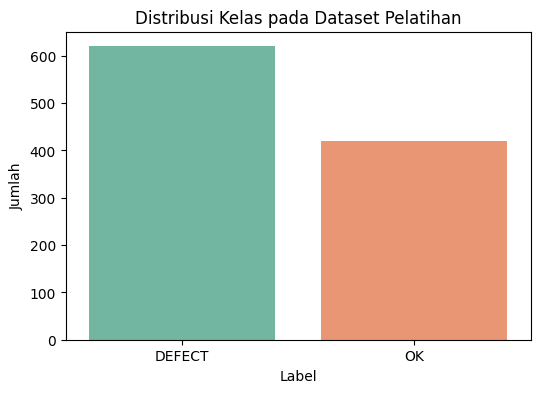

In [ ]:
import seaborn as sns
import pandas as pd

labels = []
for _, batch_labels in train_set.unbatch():
    labels.append(batch_labels.numpy())

df = pd.DataFrame({'Label': labels})
df['Label'] = df['Label'].map({0: 'OK', 1: 'DEFECT'})

plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=df, palette='Set2')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Distribusi Kelas pada Dataset Pelatihan')
plt.show()

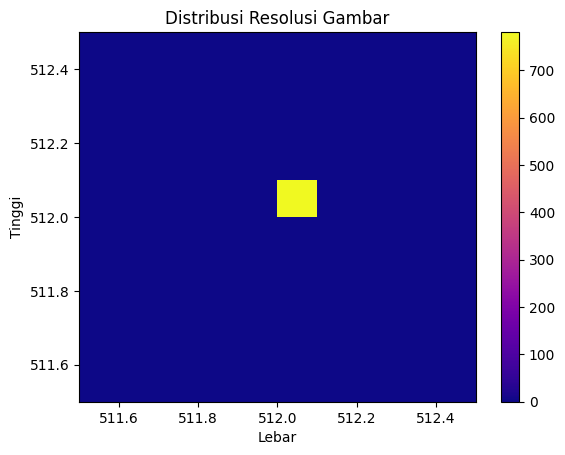

In [ ]:
import os
from PIL import Image

widths, heights = [], []
path = "/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512/def_front"

for fname in os.listdir(path):
    img = Image.open(os.path.join(path, fname))
    widths.append(img.width)
    heights.append(img.height)

plt.hist2d(widths, heights, bins=(10,10), cmap='plasma')
plt.xlabel('Lebar')
plt.ylabel('Tinggi')
plt.title('Distribusi Resolusi Gambar')
plt.colorbar()
plt.show()

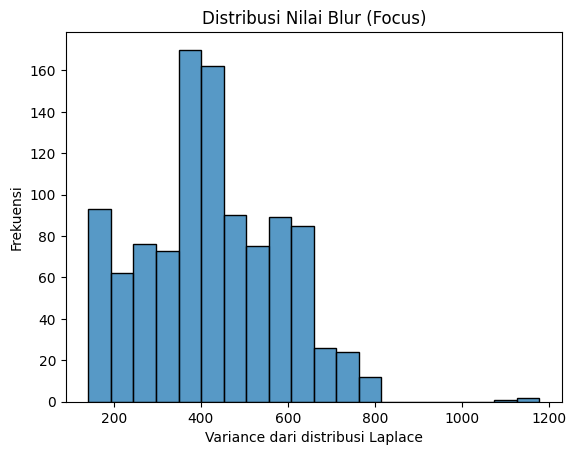

In [ ]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def variance_of_laplacian(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image # Asumsikan sudah grayscale
    return cv2.Laplacian(gray, cv2.CV_64F).var()

blurs = []
for images, _ in train_set.take(100):
    for image in images:
        img_np = image.numpy().astype("uint8")
        blurs.append(variance_of_laplacian(img_np))

sns.histplot(blurs, bins=20)
plt.title("Distribusi Nilai Blur (Focus)")
plt.xlabel("Variance dari distribusi Laplace")
plt.ylabel("Frekuensi")
plt.show()

<a id = "5"></a><br>
## 4. Visualisasi Contoh Data: Gambar Acak per Kelas

- Untuk memberikan pemahaman visual terhadap perbedaan antara produk yang cacat (“DEFECT”) dan tidak cacat (“OK”), dilakukan <b>visualisasi terhadap empat gambar acak dari dataset pelatihan</b>, masing-masing dua gambar dari setiap kelas. Proses pemilihan dilakukan dengan mengambil batch satu per satu dari dataset train_set yang telah di-unbatch dan di-shuffle menggunakan buffer agar acak. Setelah ditemukan dua gambar untuk masing-masing kelas, gambar-gambar tersebut dikombinasikan dan diacak kembali agar tampilan tidak terurut dan memberi kesan lebih natural.

- Setiap gambar ditampilkan dalam grid 2×2 lengkap dengan label klasifikasinya pada judul gambar, menggunakan warna dan ukuran yang proporsional untuk menjaga keterbacaan. Visualisasi ini tidak hanya membantu dalam memahami karakteristik visual dari kelas yang berbeda, tetapi juga berguna sebagai validasi awal bahwa proses pelabelan dan pembacaan data berjalan dengan benar. Dalam konteks implementasi model deteksi cacat berbasis visual, pemahaman terhadap bentuk dan pola citra input sangat krusial agar proses augmentasi dan pelatihan model tidak dilakukan secara “buta”.

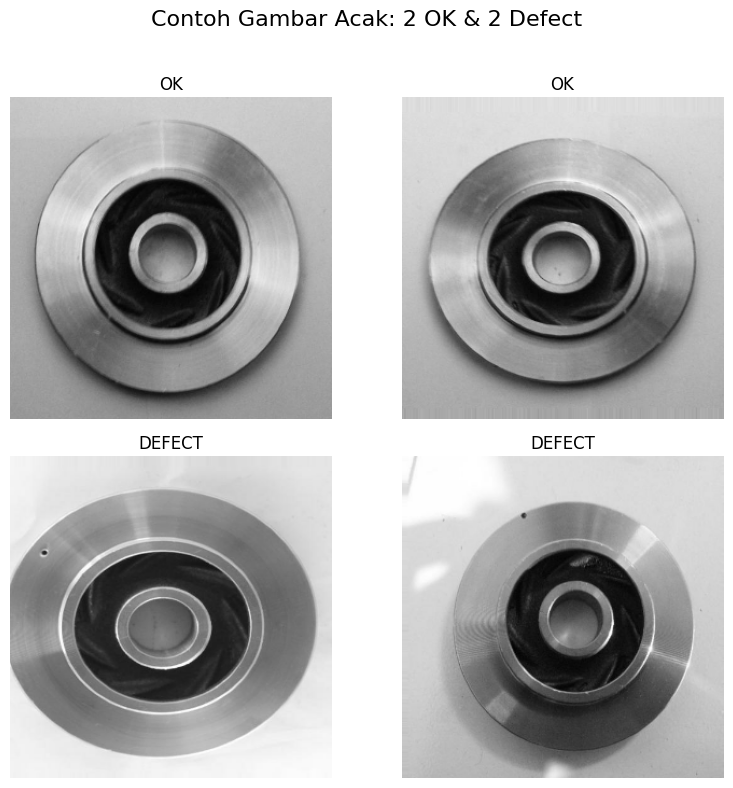

In [ ]:
import matplotlib.pyplot as plt
import random

class_names = train_set.class_names

# Siapkan list untuk menampung gambar dari masing-masing kelas
ok_samples = []
def_samples = []

# Kita akan berhenti setelah mendapatkan 2 gambar dari setiap kelas
for images, labels in train_set.unbatch().shuffle(buffer_size=1000).batch(1):
    if len(ok_samples) == 2 and len(def_samples) == 2:
        break

    label_name = class_names[labels[0].numpy()]

    if label_name == 'ok_front' and len(ok_samples) < 2:
        ok_samples.append((images[0], "OK"))

    elif label_name == 'def_front' and len(def_samples) < 2:
        def_samples.append((images[0], "DEFECT"))

# Gabungkan dan acak gambar yang sudah dipilih
selected_samples = ok_samples + def_samples
random.shuffle(selected_samples)

# Tampilkan gambar
plt.figure(figsize=(8, 8))
plt.suptitle("Contoh Gambar Acak: 2 OK & 2 Defect", fontsize=16)

for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  image, label = selected_samples[i]

  plt.imshow(image.numpy().astype("uint8"))
  plt.title(label)
  plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<a id = "6"></a><br>
## 5. Augmentasi Data beserta Visualisasinya

- Untuk meningkatkan generalisasi model dan mengurangi risiko <i>overfitting</i>, diterapkan <b>teknik augmentasi data</b> yang dirancang khusus agar relevan dengan kondisi visual nyata pada proses manufaktur. Augmentasi dilakukan menggunakan keras.Sequential, mencakup berbagai transformasi yang merepresentasikan kemungkinan variasi di dunia nyata, seperti rotasi kecil, pergeseran posisi, perubahan brightness/kontras, serta penambahan noise Gaussian. Teknik augmentasi ini bertujuan agar model mampu mengenali objek cacat meskipun terdapat perubahan pencahayaan, orientasi, atau ketajaman gambar akibat variasi kamera dan kondisi produksi.

- Untuk memastikan transformasi berjalan sesuai ekspektasi, dilakukan <b>visualisasi terhadap enam hasil augmentasi acak</b> dari satu gambar yang diambil secara acak dari dataset pelatihan. Gambar tersebut di-<i>expand</i> terlebih dahulu agar sesuai format input model, kemudian dilewatkan melalui data_augmentation dalam mode training untuk memunculkan variasi augmentasi. Hasilnya ditampilkan dalam grid 2×3, yang menunjukkan beragam versi augmentasi dari satu gambar yang sama. Dari visualisasi ini, terlihat bahwa augmentasi menghasilkan perubahan yang realistis namun tetap mempertahankan karakteristik utama dari objek, seperti bentuk dan struktur <i>impeller</i>. Ini menandakan bahwa <i>pipeline</i> augmentasi berhasil menciptakan keragaman data yang efektif untuk memperkuat robustnes model deteksi cacat.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1300).prefetch(buffer_size=AUTOTUNE)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import GaussianNoise

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3), seed=seed),
    layers.RandomZoom(0.1, seed=seed),
    layers.RandomContrast(0.3, seed=seed),
    layers.RandomRotation(0.05, seed=seed),
    layers.RandomBrightness(factor=0.2, seed=seed),
    layers.RandomTranslation(0.05, 0.05, seed=seed),
    GaussianNoise(0.05)
])

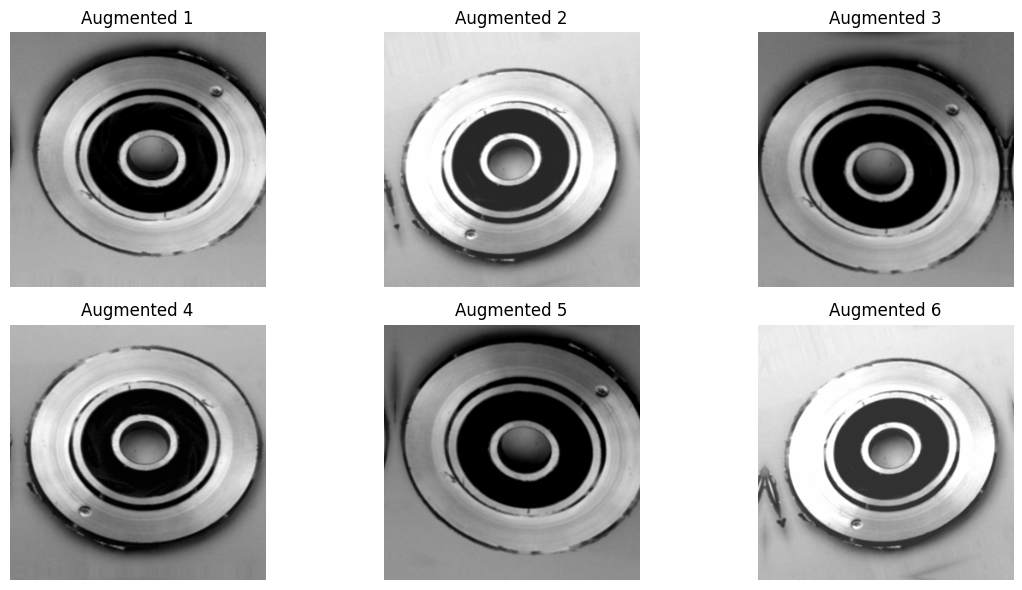

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Ambil satu batch dari train_set
for images, _ in train_set.take(1):
    random_index = np.random.randint(0, images.shape[0])
    selected_image = images[random_index]
    break

img_array = tf.expand_dims(selected_image, 0)

# Visualisasi hasil augmentasi sebanyak 6 kali
plt.figure(figsize=(12, 6))
for i in range(6):
    augmented = data_augmentation(img_array, training=True)[0].numpy().astype("uint8")
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

<a id = "7"></a><br>
## 6. Callback untuk Penghentian Otomatis dan Penyesuaian Learning Rate

- Untuk meningkatkan efisiensi proses pelatihan dan menghindari pemborosan sumber daya komputasi, digunakan dua jenis callback pada arsitektur model: myCallback dan ReduceLROnPlateau. myCallback merupakan callback kustom yang dibuat dengan mewarisi kelas tf.keras.callbacks.Callback, dan memiliki logika penghentian dini (early stopping) apabila model mencapai akurasi sempurna (100%) baik pada data pelatihan (accuracy) maupun data validasi (val_accuracy). Ketika kondisi ini tercapai, proses pelatihan akan dihentikan secara otomatis untuk <b>mencegah <i>overfitting</i> dan menghemat waktu komputasi</b>.

- Selain itu, ReduceLROnPlateau digunakan sebagai strategi adaptif untuk mengurangi nilai <i>learning rate</i> secara dinamis selama pelatihan berlangsung. <i>Callback</i> ini memantau metrik val_loss, dan jika dalam beberapa epoch berturut-turut (ditentukan oleh patience) tidak terjadi penurunan yang signifikan (lebih besar dari min_delta), maka <i>learning rate</i> akan dikalikan dengan faktor 0.5 hingga batas minimum tertentu (min_lr). Strategi ini membantu model keluar dari local minima atau plateau dengan memberikan kesempatan untuk eksplorasi yang lebih halus dalam lanskap <i>loss function</i>. Kombinasi kedua callback ini menjadikan proses pelatihan lebih cerdas, adaptif, dan efisien.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') == 1.0 and logs.get('val_accuracy') == 1.0 :
            print("\nReached 100% accuracy so cancelling training!")
            self.model.stop_training = True

terminate_callback =  myCallback()

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1,min_delta=0.01,
                              patience=5, min_lr=0.000001)



<a id = "8"></a><br>
## 7. Arsitektur Model dan Proses Pelatihan

- Bagian ini merupakan tahap utama dalam pengembangan model, yakni <b>merancang arsitektur klasifikasi citra berbasis <i>transfer learning</i></b> menggunakan model Xception. Xception dipilih karena memiliki performa unggul dalam mengekstraksi fitur visual dari citra resolusi tinggi melalui teknik <i>depthwise separable convolution</i>, yang membuatnya efisien namun tetap kuat. Dalam implementasinya, bobot pra-latih dari ImageNet digunakan (weights='imagenet'), sementara bagian atas model dihapus (include_top=False) agar bisa disesuaikan dengan tugas klasifikasi biner (cacat vs tidak cacat). Untuk menjaga efisiensi pelatihan, bagian Xception dibekukan (trainable=False) sehingga hanya lapisan atas yang dilatih ulang.

- Model dibangun menggunakan API fungsional TensorFlow dengan urutan tahapan: <b>input citra, kemudian augmentasi</b> (flip, zoom, rotasi, pencahayaan, translasi, dan noise), lalu <b>normalisasi piksel (Rescaling)</b>, <b>ekstraksi fitur via Xception</b>, flatten dense 128 unit (ReLU), dan terakhir <b>dense output 1 unit (sigmoid)</b>. Model dikompilasi menggunakan Adam optimizer dengan binary crossentropy dan dievaluasi menggunakan metrik akurasi. Proses pelatihan dijalankan <u>hingga 20 epoch</u> dengan <i>early stopping logic</i> dari terminate_callback dan penyesuaian <i>learning rate</i> otomatis via ReduceLROnPlateau. Hasil pelatihan kemudian <b>divisualisasikan melalui grafik akurasi dan loss</b>, dan <b>model akhir disimpan</b> sebagai xception_defect_model_final.keras untuk tahap inferensi dan integrasi lebih lanjut.

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))

x = data_augmentation(inputs)  # Apply random data augmentation

x = keras.layers.Rescaling(scale=1 / 255.0)(x)

x = base_model(x, training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
pretrained_model = keras.Model(inputs, outputs)

In [ ]:
pretrained_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history2 = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks= [reduce_lr, terminate_callback]
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 679s 40s/step - accuracy: 0.6769 - loss: 8.8749 - val_accuracy: 0.8308 - val_loss: 1.3830 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 671s 40s/step - accuracy: 0.8923 - loss: 1.0947 - val_accuracy: 0.9538 - val_loss: 0.2162 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 661s 39s/step - accuracy: 0.9403 - loss: 0.3295 - val_accuracy: 0.9308 - val_loss: 0.4114 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 685s 39s/step - accuracy: 0.9512 - loss: 0.2634 - val_accuracy: 0.9308 - val_loss: 0.4373 - learning_rate: 0.0010
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 649s 39s/step - accuracy: 0.9884 - loss: 0.0398 - val_accuracy: 0.9885 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 683s 41s/step - accuracy: 0.9954 - loss: 0.0109 - val_accuracy: 0.9962 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 663s 39s/step - accuracy: 0.9979 - loss: 0.0070 - 

In [ ]:
pretrained_model.save("xception_defect_model_final.keras")

In [ ]:
from tensorflow.keras.models import load_model
pretrained_model = load_model("xception_defect_model_final.keras")

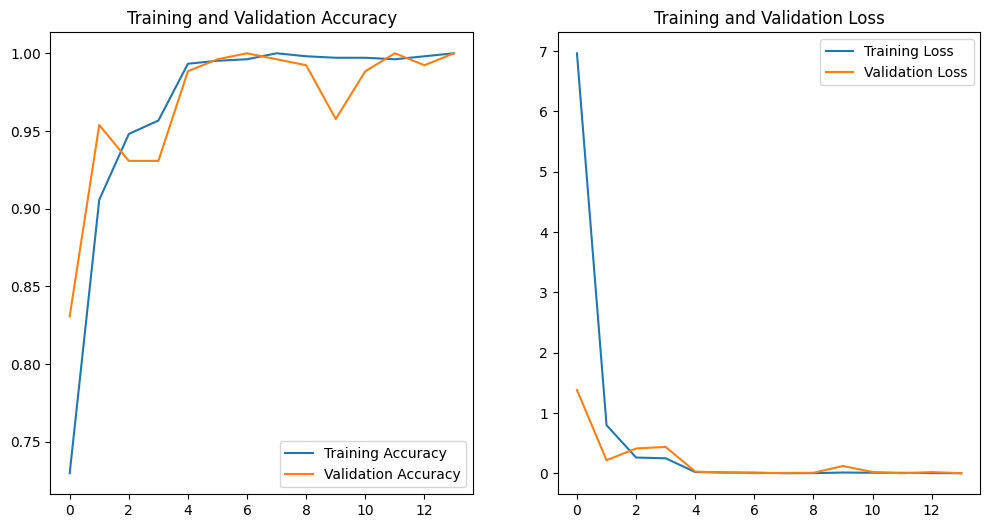

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
pretrained_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    26,214,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,505,453 (379.58 MB)

 Trainable params: 26,214,657 (100.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 52,429,316 (200.00 MB)

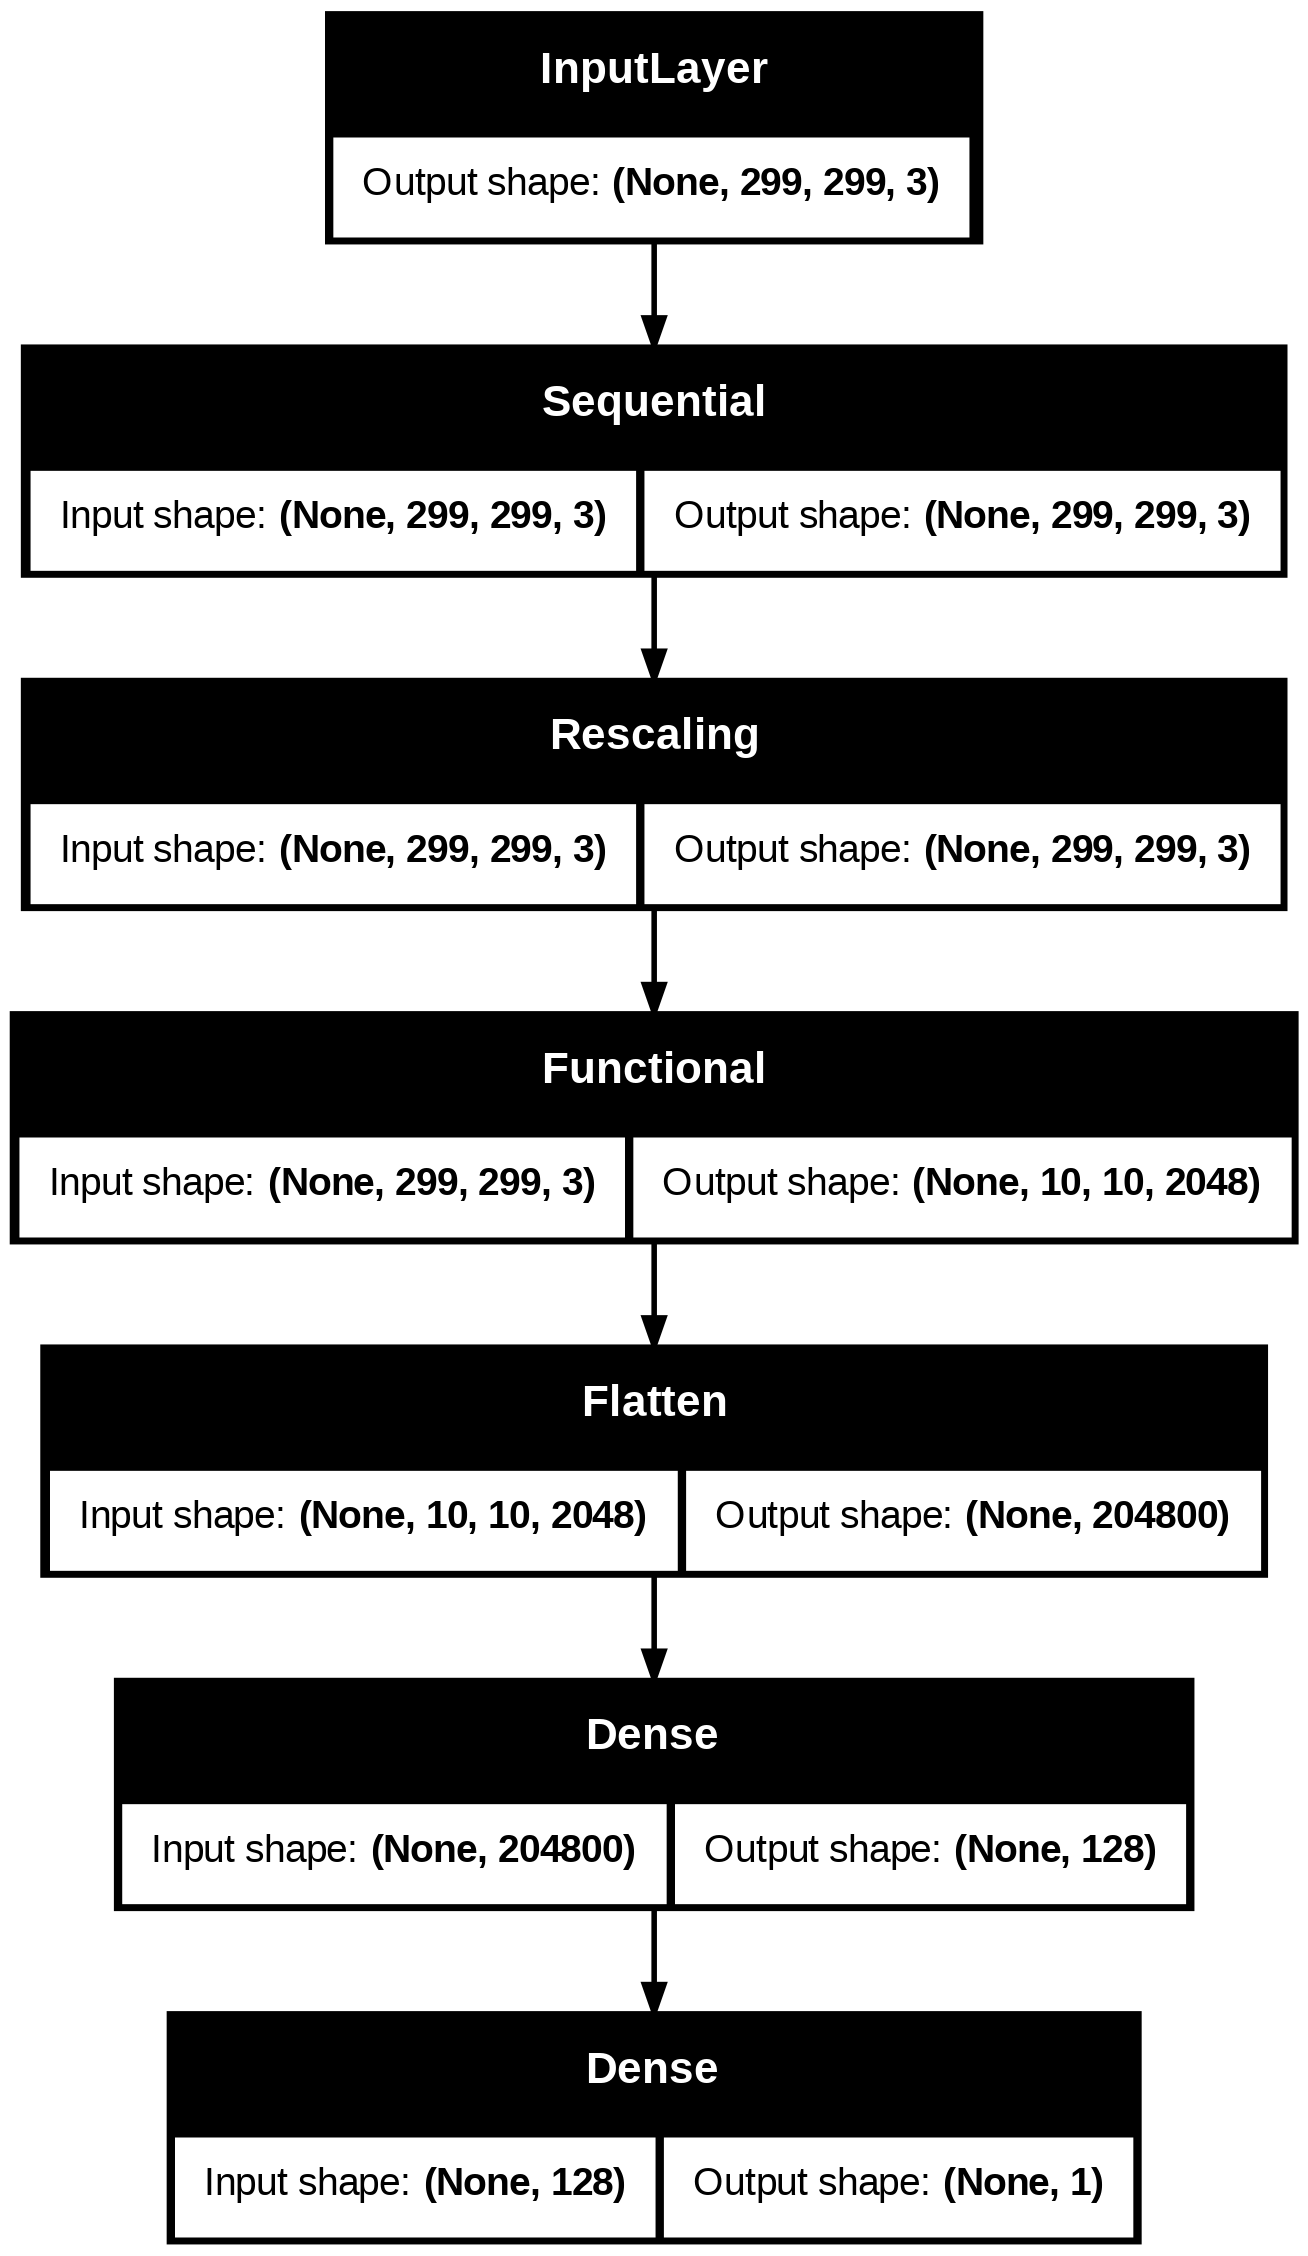

In [ ]:
keras.utils.plot_model(pretrained_model, show_shapes=True)

<a id = "9"></a><br>
## 8. Prediksi cacat menggunakan model Xception

- Bagian ini berfungsi sebagai tahap <b>visualisasi hasil inferensi</b> dari model Xception yang telah dilatih sebelumnya. Tujuannya adalah untuk mengevaluasi performa klasifikasi model terhadap citra impeller submersible pump secara acak dari kedua kelas (“ok_front” dan “def_front”). Pertama, <b>model yang telah disimpan sebelumnya dalam format .keras dimuat kembali menggunakan load_model()</b>. Kemudian, <b>semua citra dari dua direktori kelas tersebut dikumpulkan dan digabung, lalu diacak, dan 25 gambar dipilih secara acak untuk ditampilkan.</b>

- Setiap citra kemudian <b>diproses menggunakan fungsi get_img_array()</b>, yang melakukan pra-pemrosesan berupa resize dan konversi menjadi array yang sesuai dengan input model. Prediksi dilakukan oleh model, menghasilkan skor probabilitas antara 0 dan 1. Nilai threshold ditetapkan secara ketat (0.1) untuk klasifikasi, di mana skor ≤ 0.1 dianggap sebagai “OK”, dan sisanya sebagai “DEFECT”, untuk menekan kesalahan false negative dalam konteks industri. <b>Visualisasi dilakukan dengan menampilkan gambar yang telah diberi bounding box berwarna: hijau untuk “OK” dan merah untuk “DEFECT”</b>, serta judul label yang mencantumkan prediksi model beserta skor probabilitasnya. Hasil ini membantu tim teknis atau non-teknis dalam mengevaluasi model secara intuitif dan memastikan bahwa sistem deteksi dapat diandalkan dalam kondisi produksi nyata.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


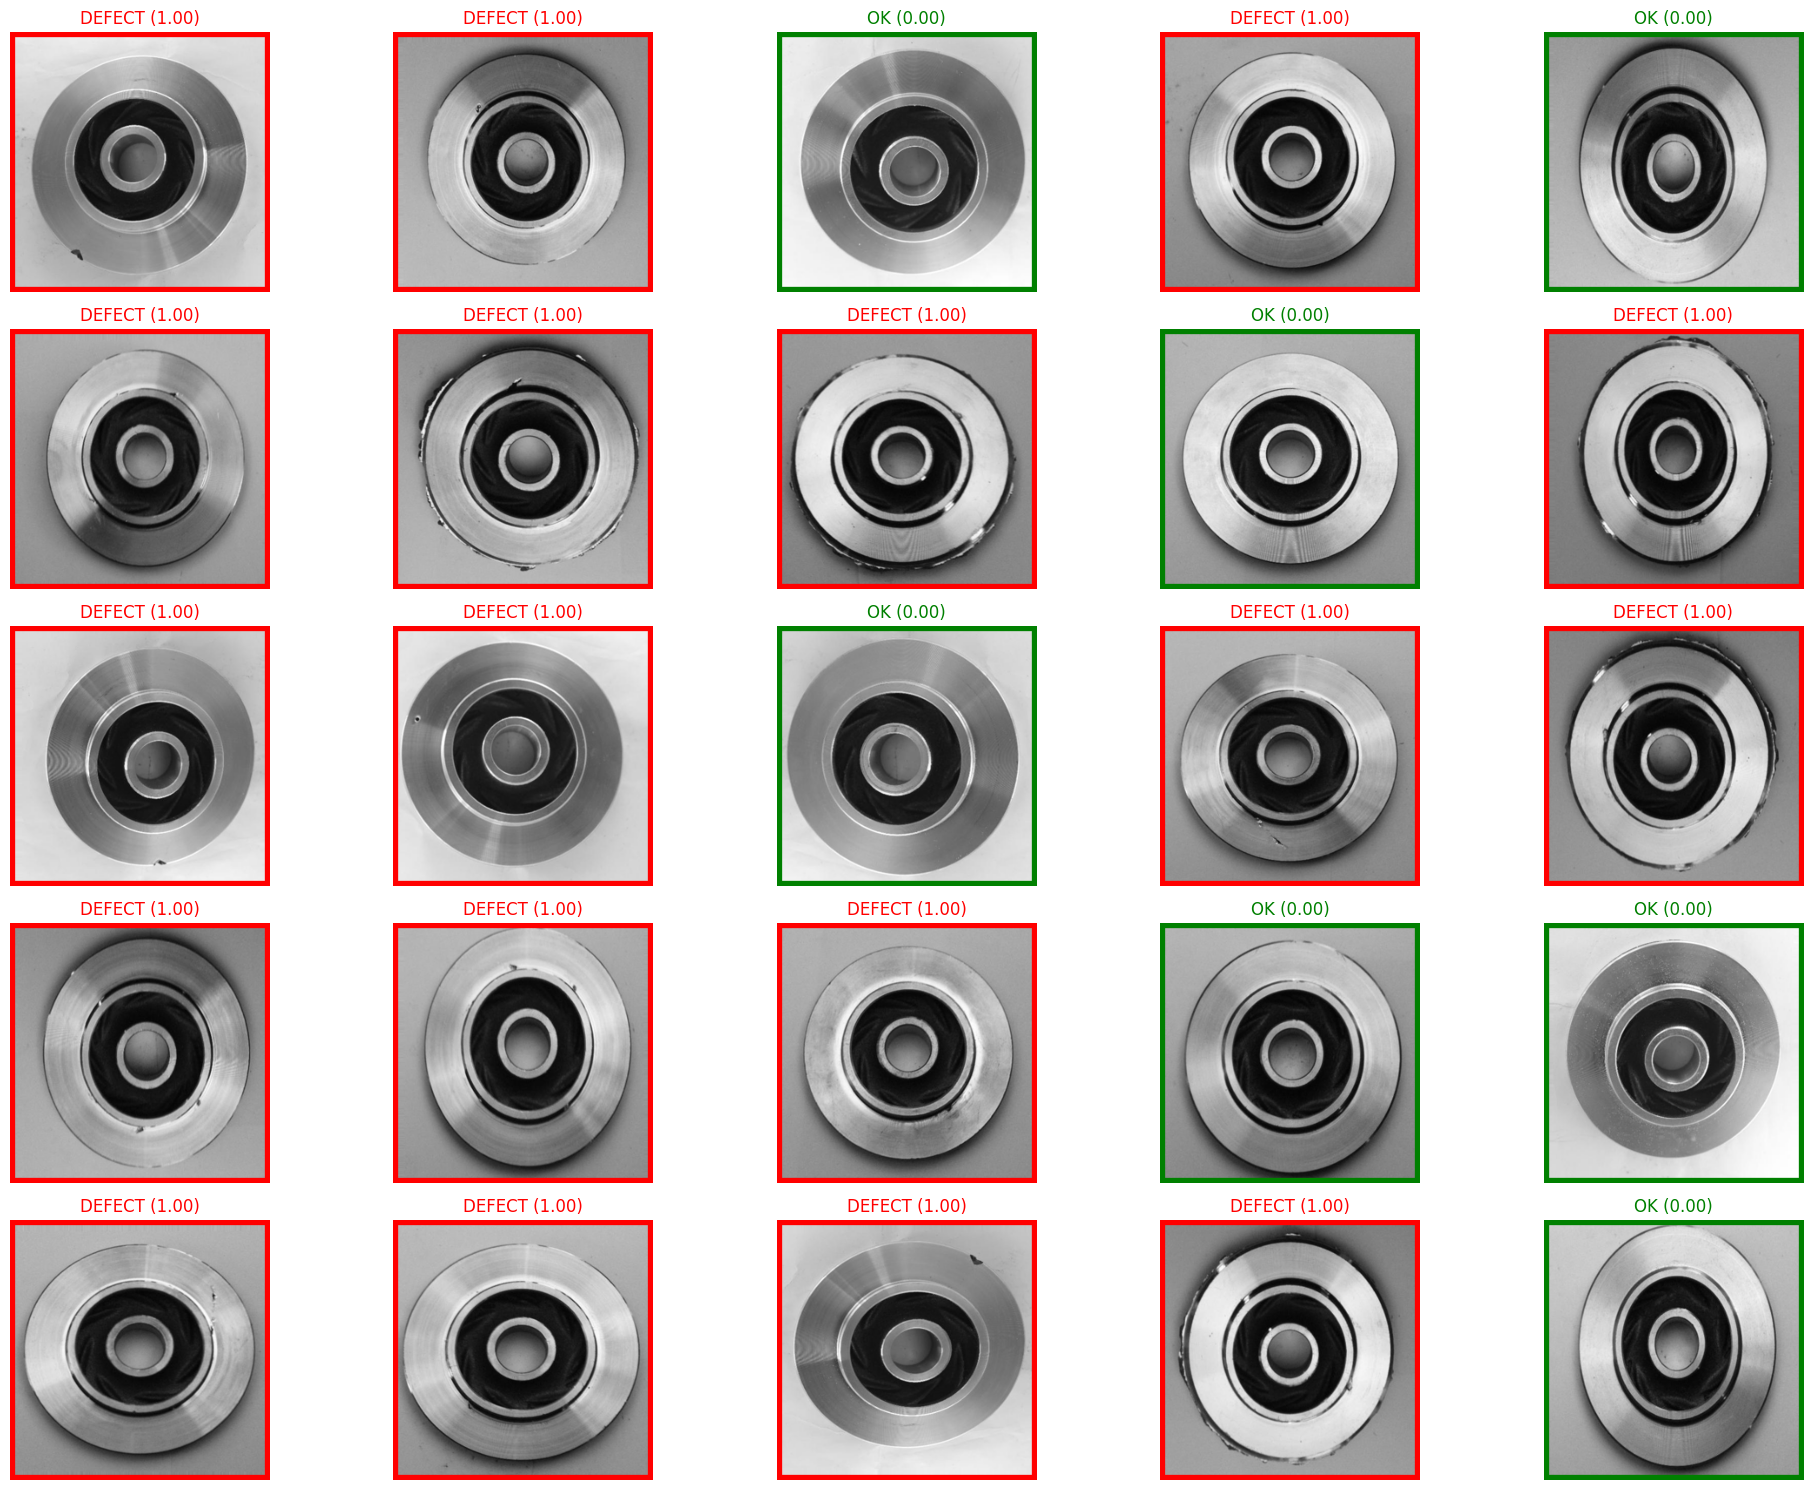

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image as PILImage, ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model

# Load the pretrained model
pretrained_model = load_model("xception_defect_model_final.keras")

base_dir = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512'
ok_dir = os.path.join(base_dir, "ok_front")
def_dir = os.path.join(base_dir, "def_front")

ok_imgs = [os.path.join(ok_dir, fname) for fname in os.listdir(ok_dir) if fname.endswith(".jpeg")]
def_imgs = [os.path.join(def_dir, fname) for fname in os.listdir(def_dir) if fname.endswith(".jpeg")]

all_imgs = ok_imgs + def_imgs
random.shuffle(all_imgs)
selected_imgs = all_imgs[:25]

img_size = (299, 299)

def get_img_array(img_path, size=(299, 299)):
    img = keras_image.load_img(img_path, target_size=size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

plt.figure(figsize=(20, 15))
columns = 5
for i, img_path in enumerate(selected_imgs):
    img_array = get_img_array(img_path, img_size)
    prediction = pretrained_model.predict(img_array)[0][0]
    label = "OK" if prediction <= 0.1 else "DEFECT"
    color = "green" if label == "OK" else "red"

    img = PILImage.open(img_path).resize(img_size)
    draw = ImageDraw.Draw(img)
    draw.rectangle([0, 0, img_size[0]-1, img_size[1]-1], outline=color, width=6)

    plt.subplot((len(selected_imgs) + columns - 1) // columns, columns, i + 1)
    plt.imshow(img)
    plt.title(f"{label} ({prediction:.2f})", color=color, fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()


<a id = "10"></a><br>
## 9. Analisis dan klasifikasi cacat secara mendalam menggunakan XAI

- Tahap ini merupakan implementasi lanjutan dari sistem deteksi cacat casting berbasis citra, dengan integrasi Grad-CAM untuk interpretabilitas serta multi-heuristic classification berbasis XAI (Explainable AI). Proses dimulai dengan<b> pemuatan gambar dari dataset dan prediksi awal menggunakan model klasifikasi Xception yang telah dilatih sebelumnya</b>. Untuk setiap citra, dilakukan evaluasi kualitas gambar untuk mendeteksi potensi blur, noise, kontras rendah, atau kecerahan ekstrem. Gambar yang lolos dari kriteria kualitas kemudian diproses melalui pipeline berbeda tergantung pada hasil klasifikasinya: jika “OK”, maka tidak dianalisis lebih lanjut; jika “DEFECT”, maka dilakukan penjelasan berbasis visual dan segmentasi.

- Untuk gambar dengan label “DEFECT”, sistem menghasilkan heatmap Grad-CAM dari model Xception asli yang telah dilatih pada ImageNet untuk mengidentifikasi area paling berkontribusi terhadap prediksi. Alih-alih hanya menampilkan heatmap, pendekatan ini menggunakan metode <b>segmentasi kontur dan bounding box</b> untuk menandai area cacat pada citra. Setiap bounding box kemudian <b>dievaluasi menggunakan fitur spasial</b> seperti area relatif, rasio aspek, kompaksi, dan circularity, lalu dilakukan <b>klasifikasi jenis cacat</b> menggunakan aturan heuristik yang disesuaikan untuk konteks industri (misalnya <u>hole, shrinkage, porosity, flash, crack, dan lainnya</u>). <b>Hasil klasifikasi ditampilkan langsung di atas gambar overlay</b>, memberikan interpretasi yang mudah dibaca bagi operator.

In [ ]:
# 1. Import dan Konfigurasi Awal

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from PIL import Image, ImageDraw
import json
import skimage.measure
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Ukuran input gambar
img_size = (299, 299)

# Direktori dataset (ganti jika jalur berbeda)
base_dir = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_512x512/casting_512x512'
ok_dir = os.path.join(base_dir, "ok_front")
def_dir = os.path.join(base_dir, "def_front")

# Ambil daftar gambar dari masing-masing folder
ok_imgs = [os.path.join(ok_dir, f) for f in os.listdir(ok_dir) if f.endswith(".jpeg")]
def_imgs = [os.path.join(def_dir, f) for f in os.listdir(def_dir) if f.endswith(".jpeg")]

# Gabungkan dan acak gambar
all_imgs = ok_imgs + def_imgs
random.shuffle(all_imgs)

# Ambil sejumlah sampel gambar untuk dianalisis (misalnya 10 gambar)
selected_imgs = all_imgs[:10]

In [ ]:
# 2. Load Model

pretrained_model = load_model("xception_defect_model_final.keras")
gradcam_model = Xception(weights='imagenet', include_top=True)
last_conv_layer_name = "block14_sepconv2_act"

print("Model berhasil dimuat.")

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model berhasil dimuat.


In [ ]:
# 3. Fungsi Preprocessing dan GradCAM

# --- Fungsi Preprocessing Gambar ---
def get_img_array(img_path, size=(299, 299)):

    img = keras_image.load_img(img_path, target_size=size)  # Baca gambar dan ubah ukurannya
    img_array = keras_image.img_to_array(img)  # Ubah menjadi array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    return img_array

# --- Fungsi Pembuatan Grad-CAM Heatmap ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # Buat model baru yang output-nya adalah layer terakhir konvolusi dan output akhir
    grad_model = tf.keras.models.Model([
        model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Hitung gradient output kelas terhadap output konvolusi
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Rata-rata gradien untuk setiap channel

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]  # Hitung kontribusi masing-masing channel
    heatmap = tf.squeeze(heatmap)

    # Normalisasi heatmap ke rentang 0 sampai 1
    heatmap = tf.maximum(heatmap, 0)
    if tf.math.reduce_max(heatmap) > 0:
        heatmap = heatmap / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

print("Preprocessing dan Grad-CAM siap digunakan.")

Preprocessing dan Grad-CAM siap digunakan.


In [ ]:
def get_bounding_boxes_from_image(image_array, threshold=100):

    # Konversi gambar ke grayscale
    gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

    # Tutupi lubang lingkaran di tengah gambar
    mask = np.ones_like(binary, dtype=np.uint8) * 255
    h, w = binary.shape
    center_x, center_y = w // 2, h // 2
    cv2.circle(mask, (center_x, center_y), 40, 0, -1)  # radius dapat disesuaikan
    binary = cv2.bitwise_and(binary, mask)

    # Temukan kontur
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > 50:
            boxes.append((x, y, x+w, y+h))
    return boxes

print("Bounding box siap digunakan")

Bounding box siap digunakan


In [ ]:
def overlay_boxes_with_all_labels(orig_img, boxes, defect_info):

# Menggambar kotak pembatas (bounding box) untuk setiap cacat beserta label dan skornya.
    orig_bgr = cv2.cvtColor(np.array(orig_img), cv2.COLOR_RGB2BGR)

    # Warna-warna berbeda untuk membedakan kotak
    distinct_colors = [
        (255, 0, 0),       # Merah
        (0, 255, 0),       # Hijau
        (0, 0, 255),       # Biru
        (255, 255, 0),     # Kuning
        (255, 0, 255),     # Magenta
        (0, 255, 255),     # Cyan
        (128, 0, 128),     # Ungu
        (255, 165, 0),     # Oranye
        (0, 128, 128),     # Teal
        (128, 128, 0),     # Olive
    ]

    for i, (x_min, y_min, x_max, y_max) in enumerate(boxes):
        # Gunakan warna unik untuk setiap kotak
        color = distinct_colors[i % len(distinct_colors)]

        # Ambil jenis cacat untuk kotak ini
        defect_entry = defect_info.get(str(i))
        if defect_entry:
            # Buat label teks dari jenis cacat dan skornya
            label_text = ", ".join(
                f"{dt['type']}({dt['score']:.2f})" for dt in defect_entry["defect_types"]
            )
        else:
            label_text = "Defect"

        # Gambar kotak pada gambar
        cv2.rectangle(orig_bgr, (x_min, y_min), (x_max, y_max), color, 2)

        # Tambahkan label teks di atas kotak
        y_text = y_min - 10
        cv2.putText(orig_bgr, label_text, (x_min, y_text),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

print("Overlay bounding box siap digunakan")

Overlay bounding box siap digunakan


In [ ]:
# --- Klasifikasi Cacat yang Ditingkatkan dengan Prediksi Berbasis XAI ---
def classify_defect_type_xai_per_cluster(cluster_groups, heatmap_shape, heatmap=None):

# Mengklasifikasikan setiap cluster secara independen dan mengembalikan hasil per cluster

    if not cluster_groups:
        return "no_defect", 0.95, {}

    total_area = heatmap_shape[0] * heatmap_shape[1]
    img_width, img_height = heatmap_shape[1], heatmap_shape[0]
    edge_threshold = 0.1
    left_edge = img_width * edge_threshold
    right_edge = img_width * (1 - edge_threshold)
    top_edge = img_height * edge_threshold
    bottom_edge = img_height * (1 - edge_threshold)

    defect_info = {}

    for cluster_id, coords in cluster_groups.items():
        coords = np.array(coords)
        area = len(coords)

        # Menghitung bounding box dari cluster
        x_min, y_min = np.min(coords, axis=0)
        x_max, y_max = np.max(coords, axis=0)
        width = x_max - x_min
        height = y_max - y_min
        bbox_area = width * height

        # Menghitung fitur-fitur bentuk cluster
        aspect_ratio = max(width, height) / max(min(width, height), 1)
        compactness = area / max(bbox_area, 1)
        relative_area = area / total_area

        # Menghitung centroid cluster
        centroid_x = np.mean(coords[:, 0])
        centroid_y = np.mean(coords[:, 1])

        # Mengecek apakah cluster berada di tepi gambar
        is_at_edge = (
            centroid_x < left_edge or centroid_x > right_edge or
            centroid_y < top_edge or centroid_y > bottom_edge
        )

        # Menghitung jarak dari pusat gambar
        center_x, center_y = img_width / 2, img_height / 2
        distance_from_center = np.sqrt((centroid_x - center_x)**2 + (centroid_y - center_y)**2)
        normalized_distance = distance_from_center / np.sqrt(center_x**2 + center_y**2)

        # Menghitung keliling dan circularity
        perimeter = 2 * (width + height)
        circularity = (4 * np.pi * area) / max(perimeter**2, 1)

        # Skor prediksi berdasarkan fitur-fitur
        scores = {
            "hole": 0.0,
            "flash_overflow": 0.0,
            "scratch": 0.0,
            "crack": 0.0,
            "porosity": 0.0,
            "shrinkage": 0.0,
            "surface_defect": 0.0,
            "inclusion": 0.0
        }

        # Aturan skoring untuk masing-masing jenis cacat
        if compactness > 0.7: scores["hole"] += 0.3
        if circularity > 0.5: scores["hole"] += 0.3
        if 0.002 < relative_area < 0.05: scores["hole"] += 0.2
        if not is_at_edge: scores["hole"] += 0.2

        if is_at_edge: scores["flash_overflow"] += 0.4
        if aspect_ratio > 2.0: scores["flash_overflow"] += 0.3
        if relative_area > 0.01: scores["flash_overflow"] += 0.3

        if aspect_ratio > 4.0: scores["scratch"] += 0.4
        if relative_area < 0.01: scores["scratch"] += 0.3
        if compactness < 0.3: scores["scratch"] += 0.3

        if aspect_ratio > 3.0: scores["crack"] += 0.3
        if relative_area > 0.005: scores["crack"] += 0.3
        if compactness < 0.4: scores["crack"] += 0.4

        if len(cluster_groups) > 2: scores["porosity"] += 0.3
        if relative_area < 0.02: scores["porosity"] += 0.3
        if compactness > 0.6: scores["porosity"] += 0.4

        if relative_area > 0.05: scores["shrinkage"] += 0.4
        if compactness < 0.6: scores["shrinkage"] += 0.3
        if not is_at_edge: scores["shrinkage"] += 0.3

        if relative_area > 0.01: scores["surface_defect"] += 0.5
        if 0.3 < compactness < 0.7: scores["surface_defect"] += 0.3

        # Skor default untuk inclusion
        scores["inclusion"] = 0.4

        # Menentukan jenis cacat dengan skor tertinggi
        defect_type = max(scores, key=scores.get)
        prediction_score = min(scores[defect_type] + 0.1, 1.0)

        # Simpan informasi cacat per cluster
        defect_info[str(cluster_id)] = {
            "defect_type": defect_type,
            "prediction_score": prediction_score,
            "area": int(area),
            "bbox": [int(x_min), int(y_min), int(x_max), int(y_max)],
            "aspect_ratio": aspect_ratio,
            "compactness": compactness,
            "relative_area": relative_area,
            "centroid": (centroid_x, centroid_y)
        }

    # Menentukan cacat utama berdasarkan area terbesar
    main_cluster = max(defect_info.items(), key=lambda x: x[1]["area"])
    return main_cluster[1]["defect_type"], main_cluster[1]["prediction_score"], defect_info

print("Klasifikasi cacat siap digunakan")

Klasifikasi cacat siap digunakan


In [ ]:
# --- Penilaian Kualitas Gambar ---
def assess_image_quality(img_array):

# Menilai kualitas gambar untuk mendeteksi blur, noise, atau anomali lainnya

    # Konversi ke grayscale jika gambar memiliki 3 channel (RGB)
    if len(img_array.shape) == 3:
        gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_array

    # Menghitung metrik blur menggunakan variansi Laplacian
    blur_metric = cv2.Laplacian(gray, cv2.CV_64F).var()

    # Menghitung metrik noise dengan standar deviasi dari hasil filter high-pass
    kernel = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
    high_pass = cv2.filter2D(gray, cv2.CV_64F, kernel)
    noise_metric = np.std(high_pass)

    # Menghitung tingkat kecerahan (brightness) dan kontras (contrast)
    brightness = np.mean(gray)
    contrast = np.std(gray)

    # Evaluasi kualitas berdasarkan ambang batas metrik
    quality_issues = []
    if blur_metric < 100:
        quality_issues.append("blurred")  # Gambar terlalu buram
    if noise_metric > 50:
        quality_issues.append("noisy")  # Terlalu banyak noise
    if brightness < 50:
        quality_issues.append("too_dark")  # Terlalu gelap
    elif brightness > 200:
        quality_issues.append("too_bright")  # Terlalu terang
    if contrast < 30:
        quality_issues.append("low_contrast")  # Kurang kontras

    return {
        'blur_metric': blur_metric,
        'noise_metric': noise_metric,
        'brightness': brightness,
        'contrast': contrast,
        'quality_issues': quality_issues
    }

print("Penilaian kualitas siap digunakan")

Penilaian kualitas siap digunakan


In [ ]:
# --- Deteksi Outlier menggunakan Isolation Forest ---
def detect_outliers(img_features):

# Deteksi gambar outlier berdasarkan fitur yang diekstraksi

    # Ekstraksi fitur untuk deteksi anomali
    features = np.array([
        img_features['blur_metric'],
        img_features['noise_metric'],
        img_features['brightness'],
        img_features['contrast']
    ]).reshape(1, -1)

    # Menggunakan pendekatan berbasis threshold sederhana untuk satu gambar
    is_outlier = False
    alasan = []

    if img_features['blur_metric'] < 50:
        is_outlier = True
        alasan.append("terlalu_buram")
    if img_features['noise_metric'] > 100:
        is_outlier = True
        alasan.append("terlalu_berisik")
    if len(img_features['quality_issues']) > 2:
        is_outlier = True
        alasan.append("terlalu_banyak_masalah_kualitas")

    return is_outlier, alasan

print("Deteksi outlier siap digunakan")

Deteksi outlier siap digunakan


In [ ]:
# --- Saran Perbaikan Cacat ---
def get_defect_suggestions(defect_type, defect_info):

# Memberikan saran perbaikan berdasarkan jenis cacat dan karakteristiknya
    suggestions = {
        "no_defect": "Produk dalam kondisi baik. Lanjutkan proses produksi.",
        "hole": "1. Periksa sistem ventilasi cetakan\n2. Kurangi kecepatan injeksi\n3. Periksa gas trap dalam cetakan\n4. Sesuaikan suhu logam cair",
        "flash_overflow": "1. Periksa tekanan clamp mesin\n2. Bersihkan parting line cetakan\n3. Sesuaikan volume material\n4. Periksa kondisi cetakan (wear)",
        "scratch": "1. Periksa kondisi cetakan dan bersihkan\n2. Gunakan pelumas cetakan yang sesuai\n3. Periksa proses ejection\n4. Hindari kontak dengan benda tajam",
        "crack": "1. Periksa suhu penuangan logam\n2. Sesuaikan kecepatan pendinginan\n3. Periksa stress concentration pada desain\n4. Kontrol gradien temperatur",
        "porosity": "1. Periksa kualitas logam cair\n2. Sesuaikan proses degassing\n3. Periksa tekanan dan waktu injeksi\n4. Kurangi kelembaban material",
        "shrinkage": "1. Sesuaikan desain sistem riser\n2. Periksa gradien pendinginan\n3. Optimalkan geometri cetakan\n4. Kontrol feeding system",
        "surface_defect": "1. Periksa kondisi permukaan cetakan\n2. Sesuaikan parameter proses casting\n3. Periksa sistem release agent\n4. Kontrol kualitas finishing",
        "inclusion": "1. Tingkatkan kualitas logam cair\n2. Periksa sistem penyaringan\n3. Bersihkan cetakan dari kontaminan\n4. Kontrol proses melting",
        "unknown": "1. Lakukan inspeksi visual lebih detail\n2. Analisis dengan metode NDT tambahan\n3. Konsultasi dengan ahli quality control"
    }

    # Ambil saran dasar sesuai jenis cacat
    base_suggestion = suggestions.get(defect_type, suggestions["unknown"])

    # Tambahkan saran tambahan berdasarkan karakteristik cacat (jika ada)
    if defect_info and defect_type != "no_defect":
        # Ambil cluster cacat dengan area terbesar
        largest_cluster = max(defect_info.items(), key=lambda x: x[1]['area'])
        props = largest_cluster[1]

        # Tambahkan saran tambahan jika area cacat besar
        if props['relative_area'] > 0.05:
            base_suggestion += "\n5. Area cacat besar - pertimbangkan untuk reject produk"
        # Tambahkan saran tambahan jika terdapat banyak cacat
        if len(defect_info) > 3:
            base_suggestion += "\n6. Terdeteksi banyak cacat - periksa keseluruhan proses produksi"

    return base_suggestion

print("Saran perbaikan siap digunakan")

Saran perbaikan siap digunakan


In [ ]:
# --- Visualisasi Tingkat Lanjut ---
def overlay_heatmap_on_image(orig_img, heatmap, cluster_groups, defect_info, alpha=0.4):

# Overlay heatmap Grad-CAM ke gambar asli dengan pewarnaan yang ditingkatkan.

    # Ubah ukuran heatmap agar sesuai dengan gambar asli
    heatmap_resized = cv2.resize(heatmap, orig_img.size)

    # Normalisasi heatmap ke rentang 0–255 dan ubah ke uint8
    heatmap_normalized = np.uint8(255 * heatmap_resized)

    # Terapkan colormap JET (biru → hijau → merah)
    heatmap_color = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

    # Konversi gambar PIL ke format OpenCV (RGB → BGR)
    orig_bgr = cv2.cvtColor(np.array(orig_img), cv2.COLOR_RGB2BGR)

    # Overlay heatmap ke gambar asli dengan alpha blending
    overlayed_img = cv2.addWeighted(orig_bgr, 1 - alpha, heatmap_color, alpha, 0)

    # Warna berbeda untuk tiap bounding box cluster
    colors = [(255, 255, 255), (0, 255, 255), (0, 165, 255), (255, 0, 255), (255, 255, 0)]

    # Gambar kotak untuk setiap cluster cacat
    for i, (cluster_id, coords) in enumerate(cluster_groups.items()):
        if cluster_id in defect_info:
            coords_array = np.array(coords)

            # Skalakan koordinat ke ukuran gambar asli
            scale_x = orig_img.size[0] / heatmap.shape[1]
            scale_y = orig_img.size[1] / heatmap.shape[0]
            coords_scaled = coords_array * [scale_x, scale_y]

            # Dapatkan bounding box dari koordinat
            x_min, y_min = np.min(coords_scaled, axis=0).astype(int)
            x_max, y_max = np.max(coords_scaled, axis=0).astype(int)

            # Gambar kotak menggunakan warna yang sesuai
            color = colors[i % len(colors)]
            cv2.rectangle(overlayed_img, (x_min, y_min), (x_max, y_max), color, 2)

            # Tambahkan label prediksi jenis cacat dan skornya
            cluster_data = defect_info.get(str(cluster_id), {})
            defect_label = cluster_data.get("defect_type", "defect")
            score = cluster_data.get("prediction_score", 0.0)
            label = f"{defect_label} ({score:.2f})"

            # Gambar teks label di atas kotak
            cv2.putText(overlayed_img, label, (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Kembalikan gambar ke format RGB untuk ditampilkan
    final_img = cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB)
    return final_img

print("Visualisasi tingkat lanjut siap digunakan")

Visualisasi tingkat lanjut siap digunakan


In [ ]:
# --- Pembuatan Laporan ---
def save_detailed_report(results, file_path="detailed_xai_classification_report.json"):

# Simpan laporan klasifikasi XAI secara rinci dalam format JSON dan ringkasan dalam TXT.

    # Susun struktur laporan utama
    report = {
        "timestamp": datetime.now().isoformat(),  # Waktu pembuatan laporan
        "total_images": len(results),  # Jumlah total gambar yang dianalisis
        "summary": {
            "ok_images": len([r for r in results if r['label'] == 'OK']),
            "defective_images": len([r for r in results if r['label'] == 'DEFECT']),
            "quality_issues": len([r for r in results if r['quality_assessment']['quality_issues']]),
            "outliers": len([r for r in results if r['is_outlier']])
        },
        "results": results
    }

    # Pastikan semua key dari defect_info adalah string (untuk keperluan JSON)
    for r in report["results"]:
        if r["defect_info"]:
            r["defect_info"] = {str(k): v for k, v in r["defect_info"].items()}

    # Simpan dalam format JSON (mudah dibaca mesin)
    with open(file_path, 'w') as f:
        json.dump(report, f, indent=2)

    # Simpan juga dalam format TXT (mudah dibaca manusia)
    with open("xai_classification_summary.txt", "w") as f:
        f.write("XAI-BASED CASTING DEFECT DETECTION REPORT\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total images analyzed: {len(results)}\n")
        f.write(f"OK images: {report['summary']['ok_images']}\n")
        f.write(f"Defective images: {report['summary']['defective_images']}\n")
        f.write(f"Images with quality issues: {report['summary']['quality_issues']}\n")
        f.write(f"Outlier images: {report['summary']['outliers']}\n\n")

        # Tulis detail per gambar
        for i, result in enumerate(results):
            f.write(f"Image {i+1}: {os.path.basename(result['image_path'])}\n")
            f.write(f"  Classification: {result['label']}\n")
            f.write(f"  Defect Type: {result['defect_type']}\n")
            f.write(f"  XAI Prediction Score: {result['xai_prediction_score']:.3f}\n")
            f.write(f"  Model Prediction Score: {result['prediction_score']:.3f}\n")
            f.write(f"  Quality Issues: {', '.join(result['quality_assessment']['quality_issues']) if result['quality_assessment']['quality_issues'] else 'None'}\n")
            f.write(f"  Is Outlier: {result['is_outlier']}\n")
            if result['is_outlier']:
                f.write(f"  Outlier Reasons: {', '.join(result['outlier_reasons'])}\n")
            f.write("\n")

print("Pembuatan laporan siap digunakan")

Pembuatan laporan siap digunakan


In [ ]:
def classify_defect_type_from_boxes(boxes, image_shape, threshold=0.15):

# Klasifikasi multi-label jenis cacat berdasarkan bounding boxes dan menggunakan skor heuristik dan threshold yang dapat disesuaikan.

    if not boxes:
        # Jika tidak ada kotak terdeteksi, anggap produk tanpa cacat
        return "no_defect", 0.95, {}

    total_area = image_shape[0] * image_shape[1]
    defect_info = {}

    for idx, (x1, y1, x2, y2) in enumerate(boxes):
        # Hitung ukuran dan fitur geometri dari bounding box
        w = x2 - x1
        h = y2 - y1
        area = w * h
        relative_area = area / total_area
        aspect_ratio = max(w, h) / max(min(w, h), 1)
        perimeter = 2 * (w + h)
        compactness = area / (w * h) if (w * h) > 0 else 0
        circularity = (4 * np.pi * area) / max(perimeter**2, 1)

        # Skor awal untuk tiap jenis cacat (semua mulai dari 0.1)
        scores = {
            "hole": 0.1,
            "shrinkage": 0.1,
            "crack": 0.1,
            "porosity": 0.1,
            "scratch": 0.1,
            "surface_defect": 0.1,
            "inclusion": 0.1
        }

        # Tambah skor berdasarkan rule/heuristik sederhana

        # Jika sangat padat dan bentuknya membulat
        if compactness > 0.7:
            scores["hole"] += 0.3
        if circularity > 0.5:
            scores["hole"] += 0.2

        # Jika area besar
        if relative_area > 0.05:
            scores["shrinkage"] += 0.3
            scores["surface_defect"] += 0.2

        # Jika area kecil
        if relative_area < 0.02:
            scores["porosity"] += 0.3
            scores["scratch"] += 0.2

        # Jika bentuknya memanjang (rasio tinggi)
        if aspect_ratio > 3.0:
            scores["crack"] += 0.3
            scores["scratch"] += 0.3
        if aspect_ratio > 4.0:
            scores["scratch"] += 0.3

        # Jika tidak padat atau bentuk tak beraturan
        if compactness < 0.4:
            scores["crack"] += 0.2
            scores["surface_defect"] += 0.2

        # Tambahan default untuk "inclusion"
        scores["inclusion"] += 0.1

        # Ambil semua jenis cacat yang melewati ambang threshold
        defect_types = []
        for defect, score in scores.items():
            if score >= threshold:
                defect_types.append({
                    "type": defect,
                    "score": round(min(score + 0.1, 1.0), 2)  # Naikkan skornya sedikit
                })

        # Jika tak ada yang lolos threshold, ambil skor tertinggi
        if not defect_types:
            max_defect = max(scores, key=scores.get)
            defect_types.append({
                "type": max_defect,
                "score": round(min(scores[max_defect] + 0.1, 1.0), 2)
            })

        # Simpan info per-box
        defect_info[str(idx)] = {
            "defect_types": defect_types,
            "area": int(area),
            "bbox": [x1, y1, x2, y2],
            "relative_area": relative_area,
            "aspect_ratio": aspect_ratio,
            "compactness": compactness,
            "circularity": circularity
        }

    # Ambil box dengan area terbesar sebagai perwakilan utama
    main_idx = max(defect_info.items(), key=lambda x: x[1]["area"])[0]
    main_defect = defect_info[main_idx]["defect_types"][0]["type"]
    main_score = defect_info[main_idx]["defect_types"][0]["score"]

    return main_defect, main_score, defect_info

print("Klasifikasi multi-label siap digunakan")

Klasifikasi multi-label siap digunakan


Setup dan inisialisasi selesai
Memproses gambar 1/10: cast_def_0_9175.jpeg
Memproses gambar 2/10: cast_def_0_7074.jpeg
Memproses gambar 3/10: cast_def_0_602.jpeg
Memproses gambar 4/10: cast_ok_0_1234.jpeg
Memproses gambar 5/10: cast_def_0_8899.jpeg
Memproses gambar 6/10: cast_ok_0_373.jpeg
Memproses gambar 7/10: cast_def_0_5572.jpeg
Memproses gambar 8/10: cast_def_0_556.jpeg
Memproses gambar 9/10: cast_def_0_1772.jpeg
Memproses gambar 10/10: cast_ok_0_3439.jpeg
Analisis selesai


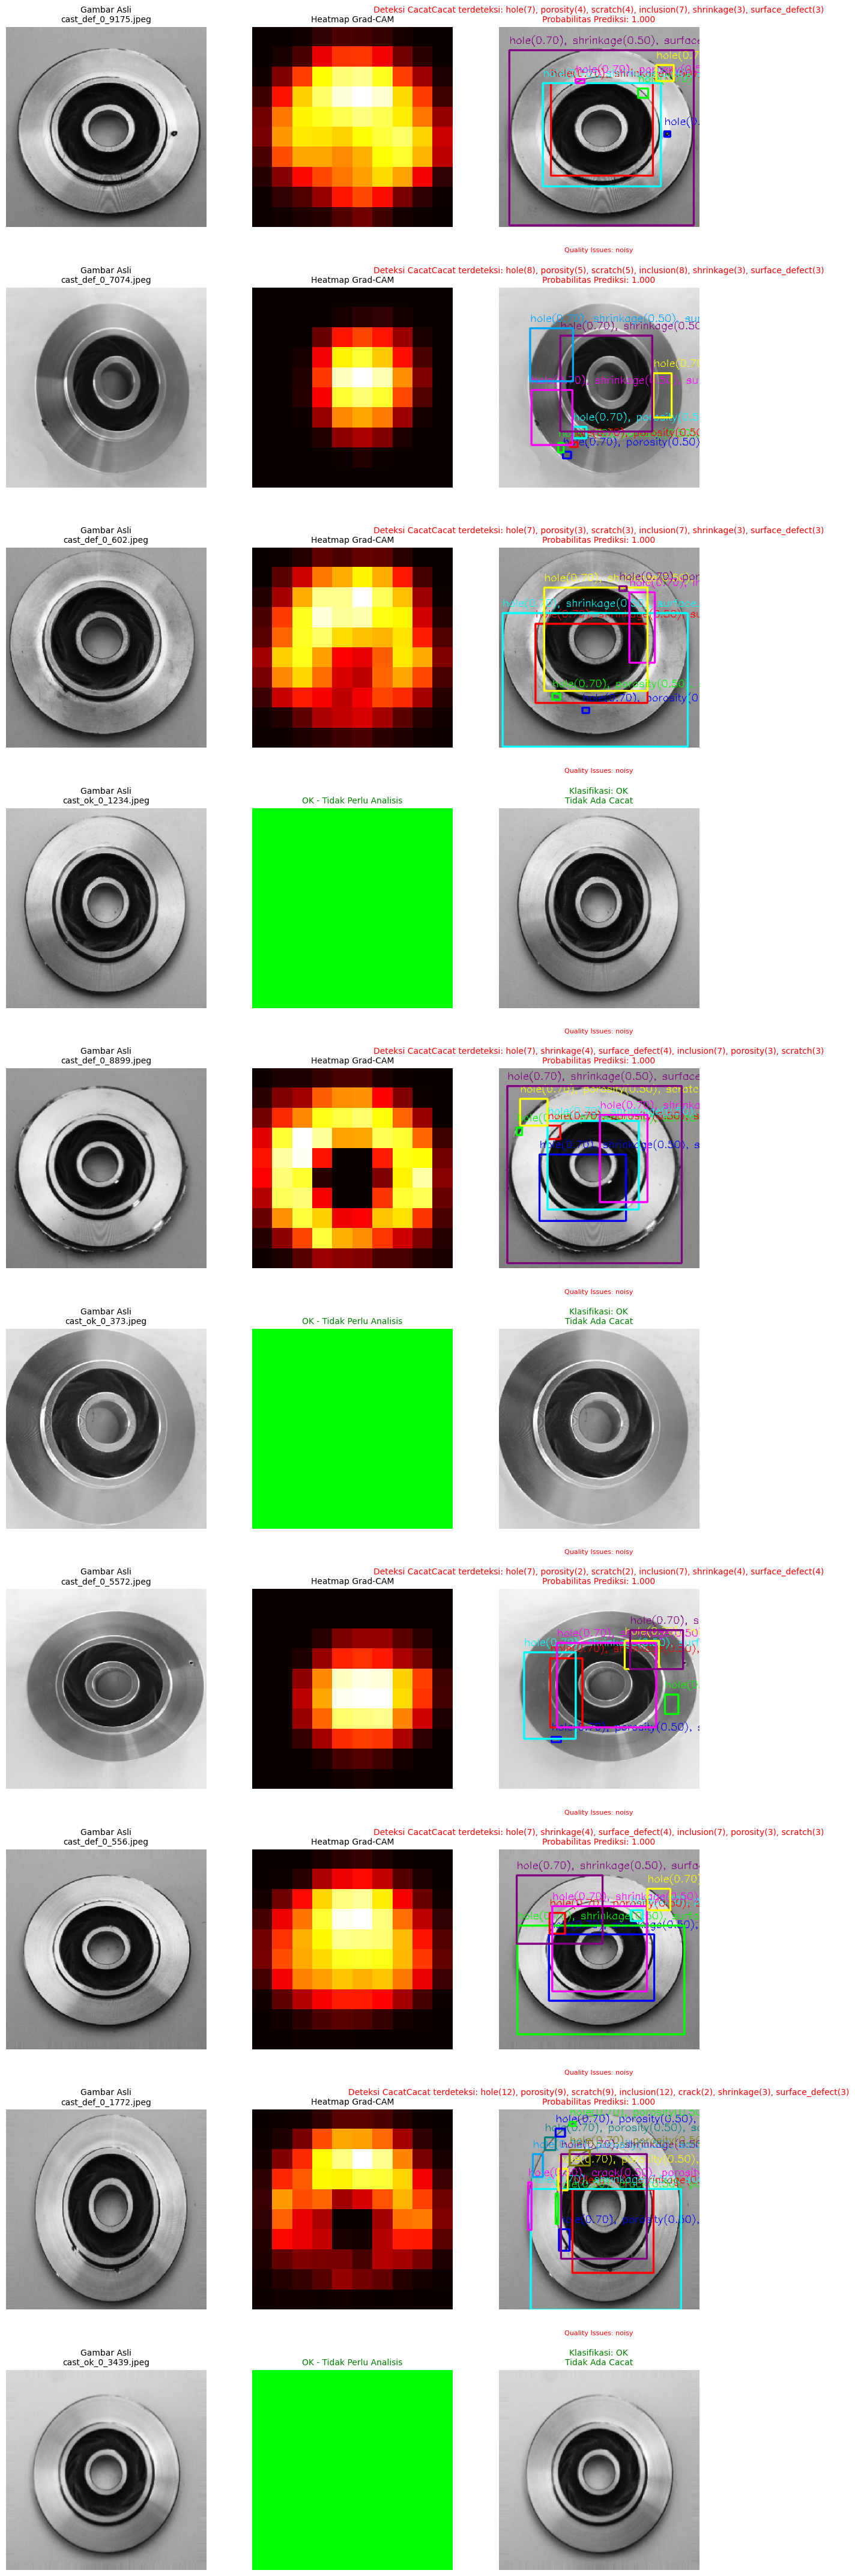

In [ ]:
# Setup dan inisialisasi
results = []
row_count = len(selected_imgs)
fig_height = row_count * 5.5

fig, axs = plt.subplots(row_count, 3, figsize=(15, fig_height))
plt.subplots_adjust(hspace=0.3)
if len(selected_imgs) == 1:
    axs = axs.reshape(1, -1)

print("Setup dan inisialisasi selesai")

for i, path in enumerate(selected_imgs):
    print(f"Memproses gambar {i+1}/{len(selected_imgs)}: {os.path.basename(path)}")

    # Load dan preprocessing gambar
    img_array = get_img_array(path, img_size)

    # Prediksi dengan model klasifikasi
    prediction = pretrained_model.predict(img_array, verbose=0)[0][0]
    is_ok = prediction <= 0.1
    label = "OK" if is_ok else "CACAT"

    # Load gambar asli
    orig = keras_image.load_img(path, target_size=img_size)

    # Evaluasi kualitas gambar
    quality_assessment = assess_image_quality(np.array(orig))

    # Deteksi outlier (gambar dengan kualitas buruk)
    is_outlier, outlier_reasons = detect_outliers(quality_assessment)

    if is_ok:
        # Jika gambar OK, tidak perlu analisis GradCAM
        defect_type = "no_defect"
        xai_prediction_score = 0.95
        defect_info = {}
        cluster_groups = {}
        heatmap = np.zeros((10, 10))  # heatmap dummy
        overlay = np.array(orig)
        suggestions = get_defect_suggestions(defect_type, defect_info)

        # Simpan hasil
        result = {
            'image_path': path,
            'prediction_score': float(prediction),
            'label': label,
            'defect_type': defect_type,
            'xai_prediction_score': xai_prediction_score,
            'has_defect': False,
            'num_clusters': 0,
            'defect_info': defect_info,
            'suggestions': suggestions,
            'quality_assessment': quality_assessment,
            'is_outlier': is_outlier,
            'outlier_reasons': outlier_reasons
        }

        # Plot hasil gambar OK
        axs[i, 0].imshow(orig)
        title = f"Gambar Asli\n{os.path.basename(path)}"
        if is_outlier:
            title += "\n⚠️ OUTLIER TERDETEKSI"
        axs[i, 0].set_title(title, fontsize=10)
        axs[i, 0].axis("off")

        # Placeholder hijau untuk heatmap
        green_img = np.zeros_like(np.array(orig))
        green_img[:, :, 1] = 255
        axs[i, 1].imshow(green_img)
        axs[i, 1].set_title("OK - Tidak Perlu Analisis", fontsize=10, color='green')
        axs[i, 1].axis("off")

        axs[i, 2].imshow(orig)
        axs[i, 2].set_title(f"Klasifikasi: {label}\nTidak Ada Cacat", fontsize=10, color='green')
        axs[i, 2].axis("off")

    else:
        # Jika gambar cacat, lakukan analisis GradCAM
        arr = keras_image.img_to_array(orig)
        input_arr = np.expand_dims(arr, axis=0)
        input_arr = preprocess_input(input_arr)

        # Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(input_arr, gradcam_model, last_conv_layer_name)

        # Deteksi area cacat dari bounding box
        orig_array = np.array(orig)
        boxes = get_bounding_boxes_from_image(orig_array, threshold=100)

        # Klasifikasi tipe cacat berdasarkan box
        defect_type, xai_prediction_score, defect_info = classify_defect_type_from_boxes(
            boxes, orig.size[::-1]
        )

        # Rekomendasi perbaikan
        suggestions = get_defect_suggestions(defect_type, defect_info)

        # Gambar overlay box + label
        overlay = overlay_boxes_with_all_labels(orig, boxes, defect_info)

        # Simpan hasil
        result = {
            'image_path': path,
            'prediction_score': float(prediction),
            'label': label,
            'defect_type': defect_type,
            'xai_prediction_score': xai_prediction_score,
            'has_defect': True,
            'num_clusters': len(boxes),
            'defect_info': defect_info,
            'suggestions': suggestions,
            'quality_assessment': quality_assessment,
            'is_outlier': is_outlier,
            'outlier_reasons': outlier_reasons
        }

        # Plot gambar cacat
        axs[i, 0].imshow(orig)
        title = f"Gambar Asli\n{os.path.basename(path)}"
        if is_outlier:
            title += "\n⚠️ OUTLIER TERDETEKSI"
        axs[i, 0].set_title(title, fontsize=10)
        axs[i, 0].axis("off")

        axs[i, 1].imshow(heatmap, cmap='hot')
        axs[i, 1].set_title("Heatmap Grad-CAM", fontsize=10)
        axs[i, 1].axis("off")

        axs[i, 2].imshow(overlay)
        from collections import Counter
        all_detected_labels = []
        for info in defect_info.values():
            for dt in info["defect_types"]:
                all_detected_labels.append(dt["type"])

        label_counts = Counter(all_detected_labels)

        if label_counts:
            summary_text = "Cacat terdeteksi: " + ", ".join(
                f"{label}({count})" for label, count in label_counts.items()
            )
        else:
            summary_text = "Tidak ada cacat terdeteksi"

        title = (
            f"Deteksi Cacat{summary_text}\nProbabilitas Prediksi: {prediction:.3f}"
        )
        axs[i, 2].set_title(title, fontsize=10, color='red')
        axs[i, 2].set_title(title, fontsize=10, color='red')
        axs[i, 2].axis("off")

    results.append(result)

    # Tambahkan peringatan kualitas gambar
    if quality_assessment['quality_issues']:
        warning_text = "Quality Issues: " + ", ".join(quality_assessment['quality_issues'])
        axs[i, 2].text(0.5, -0.1, warning_text, transform=axs[i, 2].transAxes,
                      ha='center', va='top', fontsize=8, color='red')


print("Analisis selesai")

# Simpan dan tampilkan ringkasan

plt.savefig('xai_defect_detection_results.png', dpi=300, bbox_inches='tight')
plt.show()

<a id = "11"></a><br>
## 10. Laporan Hasil Deteksi dan Self Healing Insight


- Sistem ini unggul karena <b>fitur <i>self-healing insight</i></b>: setiap jenis cacat yang terdeteksi akan secara <u>otomatis</u> disertai dengan <b>saran perbaikan (rekomendasi korektif) dalam laporan JSON dan TXT</b>. <u>Rekomendasi ini bersifat spesifik</u>, seperti “periksa suhu logam cair” untuk shrinkage atau “bersihkan cetakan” untuk defect permukaan, bahkan termasuk anjuran reject jika area cacat besar. Saran ini <b>membantu teknisi pabrik langsung mengetahui tindakan apa yang perlu diambil tanpa harus menebak-nebak</b>. Sistem ini pun <b>menyimpan visualisasi hasil</b> dalam bentuk subplot, laporan numerik, dan ringkasan outlier—membuatnya siap diintegrasikan sebagai modul pendukung quality control dan preventive maintenance di industri manufaktur berbasis logam.

In [ ]:
# Simpan laporan detail
save_detailed_report(results)

# Ringkasan analisis
print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)
print(f"Total images processed: {len(results)}")
print(f"OK images: {len([r for r in results if r['label'] == 'OK'])}")
print(f"Defective images: {len([r for r in results if r['label'] == 'DEFECT'])}")
print(f"Images with quality issues: {len([r for r in results if r['quality_assessment']['quality_issues']])}")
print(f"Outlier images: {len([r for r in results if r['is_outlier']])}")

# Distribusi tipe cacat
print("\nDefect Type Distribution:")
defect_types = {}
for r in results:
    dt = r['defect_type']
    defect_types[dt] = defect_types.get(dt, 0) + 1

for dt, count in defect_types.items():
    print(f"  {dt.replace('_', ' ').title()}: {count}")

print("\nDetail laporan disimpan pada: detailed_classification_report.json")
print("Rangkuman detail disimpan pada: classification_summary.txt")
print("Visualisasi prediksi secara detail disimpan pada: xai_defect_detection_results.png")

print("\nSemua detail telah tersimpan!")

<Figure size 640x480 with 0 Axes>


ANALYSIS COMPLETE
Total images processed: 10
OK images: 5
Defective images: 0
Images with quality issues: 6
Outlier images: 0

Defect Type Distribution:
  No Defect: 5
  Hole: 5

Detailed report saved to: detailed_classification_report.json
Summary report saved to: classification_summary.txt
Visualization saved to: xai_defect_detection_results.png

Analisis selesai


<a id = "12"></a><br>
## Penutup

Dengan pendekatan menyeluruh dari deteksi, penjelasan, hingga rekomendasi, sistem ini <b>bukan hanya sekadar alat klasifikasi, melainkan sebuah sistem pendukung keputusan</b> berbasis AI untuk manufaktur modern. <u>Grad-CAM</u> membantu teknisi memahami logika model, <u>segmentasi spasial</u> mendeteksi secara presisi, dan <u>sistem heuristik</u> menjelaskan jenis cacat seperti lubang, retakan, atau kelebihan cetakan dengan akurat. Ditambah dengan <u>evaluasi kualitas gambar, deteksi anomali, serta laporan JSON dan TXT siap integrasi</u>, sistem ini menjadi <b>komponen vital</b> dalam digitalisasi <i>quality control</i> 4.0.<br><br>
Keunggulan utamanya terletak pada <b>keterjelasan hasil, kemampuan adaptasi tanpa sensor tambahan, dan fitur self-healing berbasis data</b>, yang menjadikan sistem ini ideal untuk diterapkan dalam rantai produksi berbasis visual inspection. Dalam jangka panjang, sistem ini dapat <b>membantu perusahaan menurunkan <i>cost of poor quality (CoPQ)</i>, meningkatkan reputasi mutu produk, serta mempersingkat waktu audit dan investigasi cacat</b>. Sistem ini mendemonstrasikan bagaimana teknologi AI dapat dikemas secara praktis dan berdampak langsung pada performa bisnis industri manufaktur masa depan.